In [1]:
import sys
#sys.path.append(data_folder) # For importing utiliy.py

import keras
import numpy as np
from utility import *

from keras import models, layers, Model

Using TensorFlow backend.


In [2]:
embedding_size = 64
TAG2VEC_FILE = 'tag_list_word2vec_' + str(embedding_size) + '.npz'
IMAGE_FEAT_FILE = 'harrison_features.npz'
MODEL_NAME = 'im_hashtag_model.h5'

In [3]:
# Load Hashtag-to-Vector file
from packaging import version
t2v_data = None
if version.parse(np.__version__) > version.parse("1.16.2"):
    t2v_data = np.load(TAG2VEC_FILE, allow_pickle=True) # word_count, dictionary, reverse_dictionary, word_embeddings
else:
    t2v_data = np.load(TAG2VEC_FILE) # word_count, dictionary, reverse_dictionary, word_embeddings
    
tag_dictionary = t2v_data['dictionary'].tolist()
tag_reverse_dict = t2v_data['reverse_dictionary'].tolist()
tag_embeddings = t2v_data['word_embeddings']

In [4]:
# Load ImageNet features
feat_data = np.load(IMAGE_FEAT_FILE)
imnet_fc_feats = feat_data['imagenet_fc_layers']
place_fc_feats = feat_data['places365_fc_layers']
image_list = feat_data['image_list']
tag_strings = feat_data['hashtag_list']
train_indices = feat_data['train_indices']
test_indices = feat_data['test_indices']

In [5]:
# Get HARRISON labels
labels = img_paths_to_labels(image_list)

# Get word vector of each image
image_t2v = []
for label in labels:
    if label in tag_dictionary:
        tagID = tag_dictionary[label]
        image_t2v.append(tag_embeddings[tagID])
    else:
        print(label, "doesn't exist!")

image_t2v_mat = np.array(image_t2v)

In [6]:
# Split data into train/test set
train_x = imnet_fc_feats[train_indices, :]
test_x = imnet_fc_feats[test_indices, :]
train_y = image_t2v_mat[train_indices, :]
test_y = image_t2v_mat[test_indices, :]

In [7]:
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [8]:
model = models.Sequential()
model.add(layers.Conv1D(128,kernel_size= 1,input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu' ))
model.add(layers.Dense(embedding_size))
#-------------
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [9]:
history = model.fit(train_x, train_y, epochs=20, batch_size=512, verbose=1)

Epoch 1/20
38255/38255 [==============================] - 49s 1ms/step - loss: 0.0153 - mean_absolute_error: 0.0976
Epoch 2/20
38255/38255 [==============================] - 3s 67us/step - loss: 0.0109 - mean_absolute_error: 0.0839
Epoch 3/20
38255/38255 [==============================] - 1s 36us/step - loss: 0.0104 - mean_absolute_error: 0.0817
Epoch 4/20
38255/38255 [==============================] - 1s 36us/step - loss: 0.0102 - mean_absolute_error: 0.0805
Epoch 5/20
38255/38255 [==============================] - 1s 35us/step - loss: 0.0100 - mean_absolute_error: 0.0797
Epoch 6/20
38255/38255 [==============================] - 1s 35us/step - loss: 0.0099 - mean_absolute_error: 0.0790
Epoch 7/20
38255/38255 [==============================] - 1s 36us/step - loss: 0.0098 - mean_absolute_error: 0.0784
Epoch 8/20
38255/38255 [==============================] - 1s 36us/step - loss: 0.0097 - mean_absolute_error: 0.0779
Epoch 9/20
38255/38255 [==============================] - 1s 35us/step -

In [10]:
model.save_weights(MODEL_NAME)

In [10]:
#### Evaluate DeViSE Model ####
model.evaluate(test_x, test_y)

19128/19128 [==============================] - 4s 217us/step


[0.009353713408410113, 0.07545456507436803]

In [11]:
pred_y = model.predict(test_x)

In [12]:
# Convert HARRISON tag ground-truth string into wordID
tag_list, miss_tags = tag_string_to_w2v_id(tag_strings, tag_dictionary)
test_tag_list = []
for tid in test_indices:
    test_tag_list.append(tag_list[tid])

In [13]:
# Calculate K-Nearest Neighbor of predicted y (tag-vector)
KNN = 10
knn_list = []
for pred in pred_y:
    knn_list.append(get_knn(pred, tag_embeddings, KNN))

In [14]:
recall_rate, recall_list = cal_recall_rate(knn_list, test_tag_list)
print('The recall rate of our model is', recall_rate)

The recall rate of our model is 0.185057722632106


In [15]:
test_labels = []
for tid in test_indices:
    #test_tag_list.append(tag_list[tid])
    test_labels.append(labels[tid])
    
recall_rates, _ = cal_class_recall(test_labels, recall_list, test_tag_list)

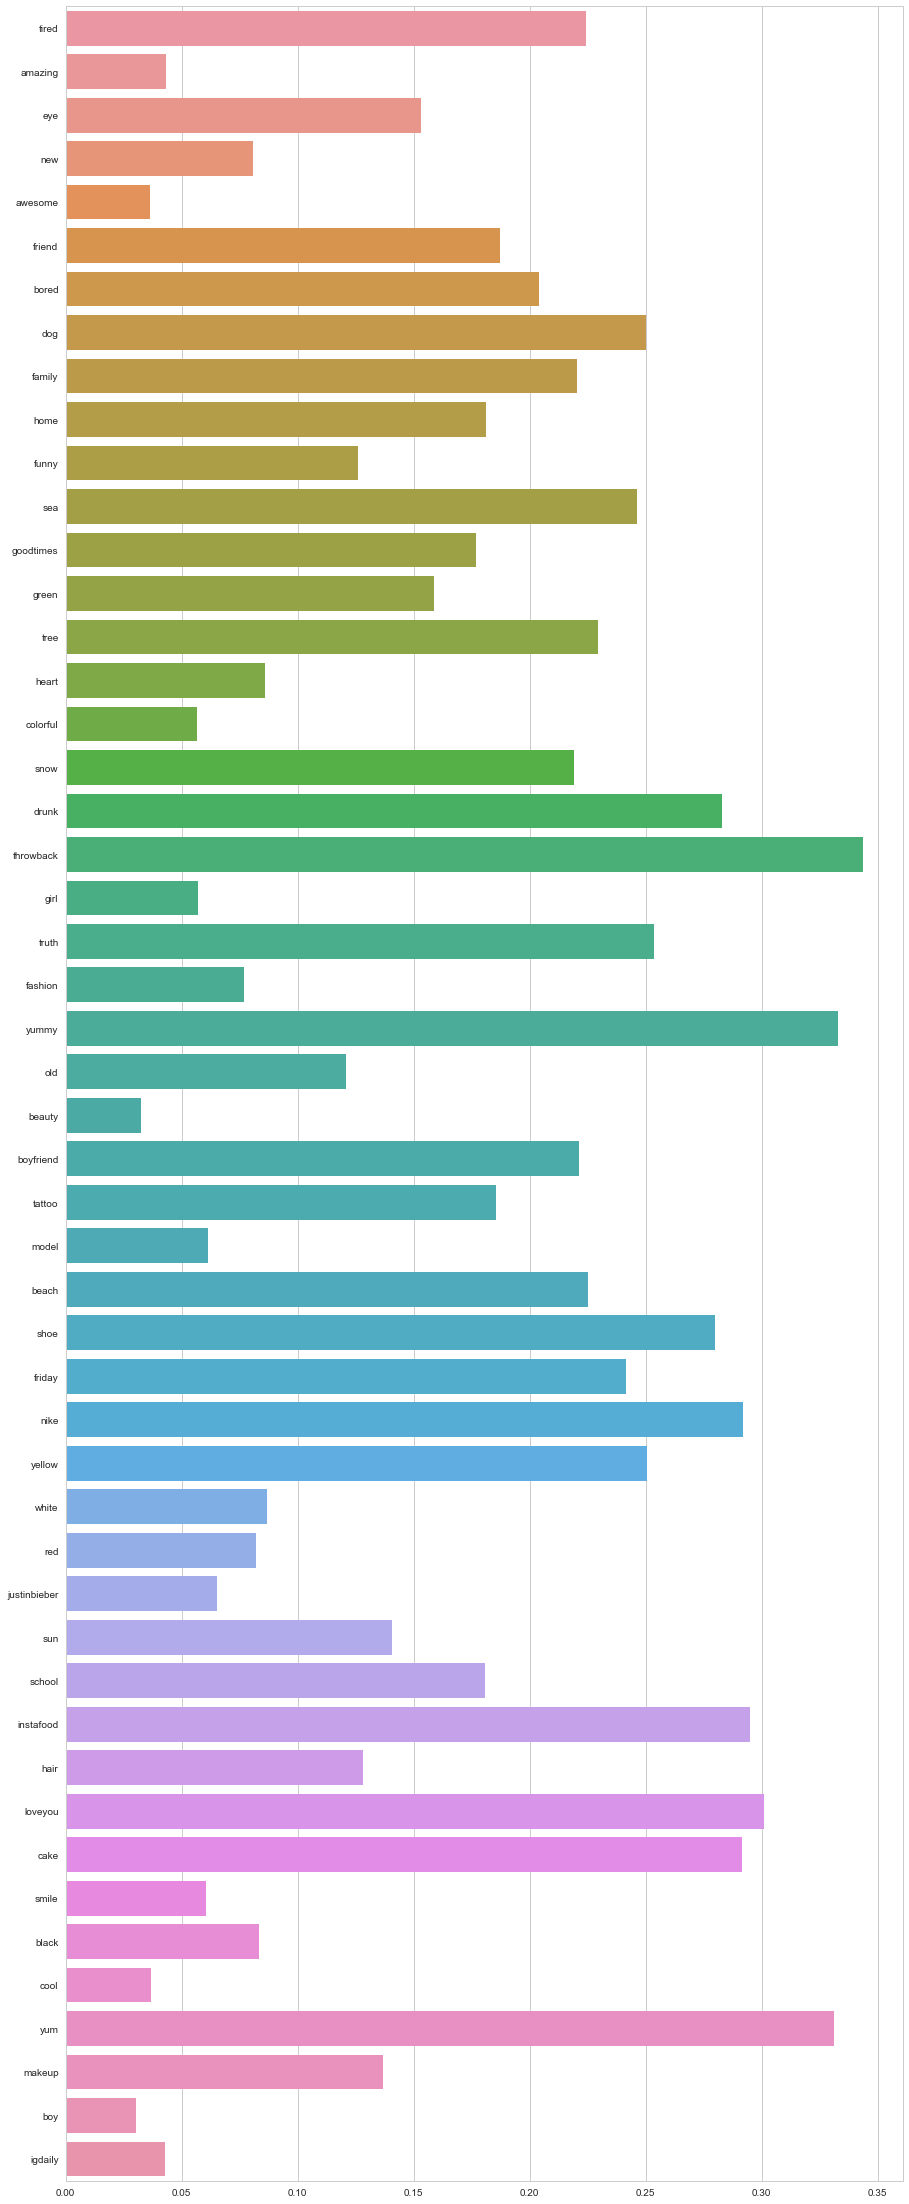

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,40))
sns.set(style="whitegrid")
ax = sns.barplot(x=list(recall_rates.values()), y=list(recall_rates.keys()))

### cal_hamming_loss

In [17]:
loss, result_list = cal_hamming_loss(knn_list, test_tag_list)
print('Hamming loss (lower is better): %s' % loss)

Hamming loss (lower is better): 0.814942277367894


In [36]:
save_kaggle_hamming_loss_csv('predict_4_kaggle.csv', result_list)